### Install `mmk` and its dependencies

In [ ]:
!git clone https://github.com/k-tonal/mmk.git
!pip install -r mmk/requirements.txt

### load the api token of your neptune account

In [3]:
from getpass import getpass
api_token = getpass('Enter your private Neptune API token: ')

Enter your private Neptune API token: ········


### Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
plt.rcParams['figure.figsize'] = (20, 6)
import torch
import torch.nn as nn
import numpy as np
import os

# class defining the class of FreqNet models and the dictionary to subclass it
from mmk.models.model_base import Model

# generate function 
from mmk.modules.generate import generate

# data utils
from mmk.data import Database

# debug, interact
from mmk.utils import show, audio, download_database, download_model, upload_model

mmk initialized with device: cuda


### download some data and load it here

In [3]:
db_name = "gould.h5"
# download_database(api_token, project_name="k-tonal/data", experiment_id="DAT-1", database_name=db_name)
db = Database(db_name)
db.metadata

,start,stop,duration,name
0,0,4190,4190,"gould/07 Invention 14 in B-flat major, BWV 785"
1,4190,12541,8351,"gould/26 Sinfonia 4 in D minor, BWV 790"
2,12541,16485,3944,"gould/16 Sinfonia 7 in E minor, BWV 793"
3,16485,19451,2966,"gould/08 Sinfonia 14 in B-flat major, BWV 800"
4,19451,22971,3520,"gould/05 Invention 5 in E-flat major, BWV 776"
5,22971,25310,2339,"gould/09 Invention 11 in G minor, BWV 782"
6,25310,29202,3892,"gould/01 Invention 1 in C major, BWV 772"
7,29202,37210,8008,"gould/06 Sinfonia 5 in E-flat major, BWV 791"
8,37210,39439,2229,"gould/13 Invention 15 in B minor, BWV 786"
9,39439,46676,7237,"gould/29 Invention 9 in F minor, BWV 780"


## Hierarchical Kernel

HK has 2 options :

1. `overlap = [True, False]` which is shown in the next figure

2. `include_layer_0 = [True, False]` which specifies whether the input time-steps are included in the inputs to the HK

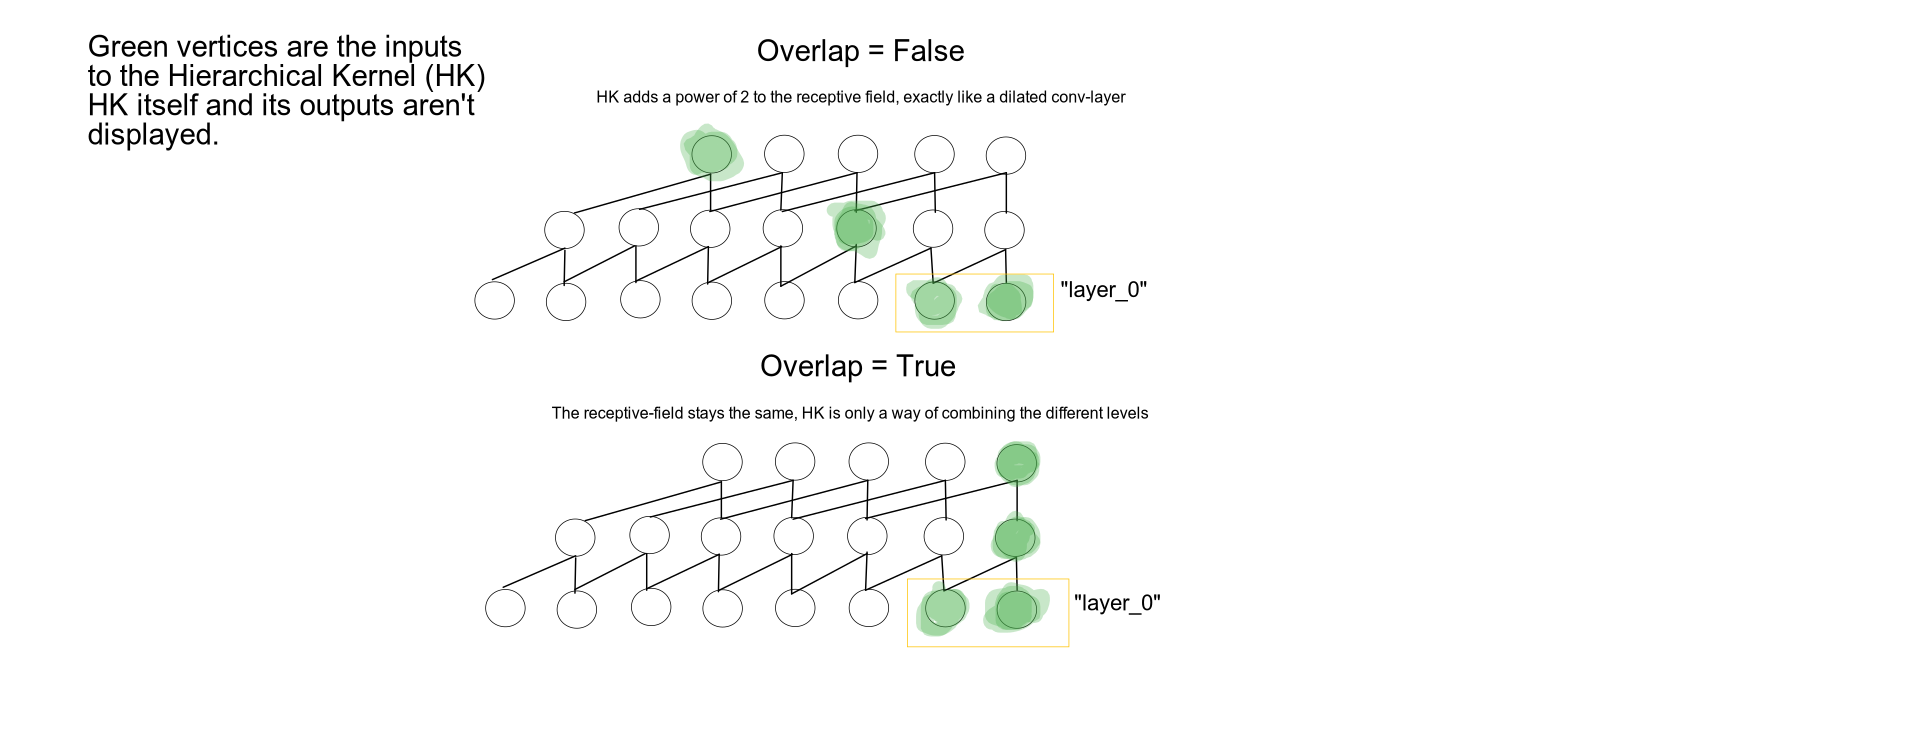

In [107]:
class HKMethods(object):
    """
    Base class that implements the reshaping of inputs
    """
    # attributes that configure the connectivity
    overlap = False
    include_layer_0 = True
    
    def repeat_input_layer(self, x):
        B, D, T = x.size()
        y = torch.stack((x[:, :, :-1], x[:, :, 1:]), dim=1)
        return y.permute(0, 2, 3, 1).contiguous()
    
    def as_input_disj(self, layers, shifts):
        """
        version with disjunct receptive fields
        """
        T = layers[0].size(-1)
        offsets = (*np.cumsum(shifts[::-1])[::-1], 0)
        n_inpt = T - offsets[0] - 1
        inpt = torch.stack(tuple(x[:, :, start:start+n_inpt]
                            for x, start in zip(layers[1:], offsets[1:])), dim=-1)
        if self.include_layer_0:
            layers[0] = self.repeat_input_layer(layers[0][:, :, offsets[0]:])
            return torch.cat((layers[0], inpt), dim=-1)
        return inpt
        
    def as_input_ovl(self, layers, shifts):
        """
        version with overlapping receptive fields
        """
        T = layers[-1].size(-1)
        inpt = torch.stack(tuple(x[:, :, -T:]
                            for x in layers[1:]), dim=-1)
        if self.include_layer_0:
            layers[0] = self.repeat_input_layer(layers[0][:, :, -T-1:])
            return torch.cat((layers[0], inpt), dim=-1)
        return inpt

#### N.B. :

for now, HK doesn't adapt to `strict` layers! So, please use layer_functions with `strict=False`

#### possible TODOS to improve efficiency :

- trim inputs to standard conv layers (instead of discarding the conv-layers outputs in the HK)
- split the HK into "output_kernels" at the end of each layer and just sum the right time-steps at the end of the network

## Two different Networks implementations 

1. HK in place of the last convolutional layer

2. HK in place of the Linear decoder at the end of the network

### HK in place of the last convolutional layer

In [114]:
from mmk.models.freqnet import FreqLayer, FreqBlock, FreqNet, layer_funcs
from mmk.modules import GatedLinearInput, AbsLinearOutput


class HierarchicalKernel(nn.Module, HKMethods):
    def __init__(self, c_in, c_out, n_layers, overlap=False, include_layer_0=True, **kwargs):
        super(HierarchicalKernel, self).__init__()
        self.overlap = overlap
        self.include_layer_0 = include_layer_0
        self.conv_f = nn.Conv2d(c_in, c_out, (1, n_layers + 2 * int(include_layer_0)), **kwargs)
        self.conv_g = nn.Conv2d(c_in, c_out, (1, n_layers + 2 * int(include_layer_0)), **kwargs)
        
    def forward(self, layers, shifts):
        """
        layers: input of shape (Batch x Dimensionality x Time x Layer)
        """
        method = self.as_input_ovl if self.overlap else self.as_input_disj
        x = method(layers, shifts)
        f = nn.Tanh()(self.conv_f(x))
        g = nn.Sigmoid()(self.conv_g(x))
        return (f * g).squeeze(-1)
    
    
class HierarchicalFreqBlock(nn.Module):
    @property
    def shifts(self):
        return tuple(2**(i+1) for i in range(len(self.block)))
    
    def __init__(self,model_dim, n_layers, layer_func,
                 overlap=False, include_layer_0=True, hk_groups=4, **kwargs):
        super(HierarchicalFreqBlock, self).__init__()
        self.block = nn.ModuleList(
            [FreqLayer(model_dim,
                      dilation=2 ** i, **kwargs) for i in range(n_layers)])
        self.layer_func = layer_func
        self.head = HierarchicalKernel(model_dim, model_dim,
                                       n_layers, overlap, include_layer_0, groups=hk_groups)
        
    def forward(self, x, skip):
        layers = [x]
        for i, layer in enumerate(self.block):
            x, skip = self.layer_func(layer, x, skip)
            layers += [skip]
        skip = self.head(layers, self.shifts)
        return x, skip
    
    
class HKFreqNet(FreqNet):
    
    @property
    def shift(self):
        return sum(2 ** (i + int(not self.hk_overlap)) + i * int(self.is_strict()) for i in self.layers)

    @property
    def receptive_field(self):
        return sum(2 ** (i + int(not self.hk_overlap)) for i in self.layers)
    
    def __init__(self, **kwargs):
        super(HKFreqNet, self).__init__(**kwargs)

        model_dim = self.model_dim
        layer_f, learn_padding = self.lf[0], self.learn_padding
        conv_kwargs = getattr(self, "conv_kwargs", {})

        # Input Encoder
        self.inpt = GatedLinearInput(self.input_feature.dim, model_dim)

        # Autoregressive Part
        self.blocks = nn.ModuleList([
            HierarchicalFreqBlock(model_dim, n_layers, layer_f,
                                  self.hk_overlap, self.hk_include_layer_0, self.hk_groups,
                                  strict=self.is_strict(),
                                  learn_padding=learn_padding,
                                  **conv_kwargs)
            for n_layers in self.layers
        ])

        # Output Decoder
        self.outpt = AbsLinearOutput(model_dim, self.input_feature.dim)

In [115]:
fnet = HKFreqNet(
    # data :
    input_feature=db.fft,
    train_set=db.metadata.iloc[[0, ]],
    # model architecture
    model_dim=512,
    conv_kwargs=dict(groups=1),
    learn_padding=False,
    lf=layer_funcs["residuals_left"],
    
    ####################################
    # if overlap=False => HK adds a power of 2 to the receptive field
    # if overlap=True => receptive-field stays the same
    layers=(int(np.log2(8)),),
    ####################################
    
    # HK params
    hk_overlap=False,
    hk_groups=8,
    hk_include_layer_0=False,
    
    # training
    max_lr=5e-4,
    batch_size=64,
    sequence_length=64,
    max_epochs=100,
    # file-system
    overwrite=True,
    name="hk_gould",
    root_dir="hierarchical-kernels/",
    era_duration=50,
)

print("shift:", fnet.shift, "receptive_field:", fnet.receptive_field)

trainer = fnet.get_trainer()
trainer.fit(fnet)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type             | Params
--------------------------------------------
0 | inpt   | GatedLinearInput | 1 M   
1 | blocks | ModuleList       | 4 M   
2 | outpt  | AbsLinearOutput  | 525 K 


shift: 16 receptive_field: 16


initialized directory: hierarchical-kernels/hk_gould/v0/



Training finished after 0 days 0 hours 0 mins 3 seconds


1

---

## HK in place of the final Decoder

In [102]:
from mmk.models.freqnet import FreqBlock, FreqNet
from mmk.modules import GatedLinearInput, AbsLinearOutput


class HierarchicalKernelHead(nn.Module, HKMethods):
    @property
    def shifts(self):
        return tuple(2**(i+1) for i in range(self.n_layers))
    
    def __init__(self, c_in, c_out, n_layers, overlap=False, include_layer_0=True, **kwargs):
        super(HierarchicalKernelHead, self).__init__()
        self.overlap = overlap
        self.include_layer_0 = include_layer_0
        self.conv = nn.Conv2d(c_in, c_out, (1, n_layers + 2 * int(include_layer_0)), **kwargs)
        self.n_layers = n_layers
        
    def forward(self, layers):
        """
        layers: input of shape (Batch x Dimensionality x Time x Layer)
        """
        method = self.as_input_ovl if self.overlap else self.as_input_disj
        x = method(layers, self.shifts)
        x = self.conv(x).abs()
        return x.squeeze(-1).transpose(1, 2).contiguous()

    
class CachedFreqBlock(FreqBlock):
    def forward(self, x, skip):
        layers = [x]
        for i, layer in enumerate(self.block):
            x, skip = self.layer_func(layer, x, skip)
            layers += [skip]
        return x, layers
    
class HKFreqNet(FreqNet):
    
    @property
    def shift(self):
        return sum(2 ** (i + int(not self.hk_overlap)) + i * int(self.is_strict()) for i in self.layers)

    @property
    def receptive_field(self):
        return sum(2 ** (i + int(not self.hk_overlap)) for i in self.layers)
    
    
    def __init__(self, **kwargs):
        super(HKFreqNet, self).__init__(**kwargs)

        model_dim = self.model_dim
        input_dim = self.input_feature.dim
        layer_f, learn_padding = self.lf[0], self.learn_padding
        conv_kwargs = getattr(self, "conv_kwargs", {})

        # Input Encoder
        self.inpt = GatedLinearInput(input_dim, model_dim)

        # Autoregressive Part
        self.blocks = nn.ModuleList([
            CachedFreqBlock(model_dim, n_layers, layer_f,
                      strict=self.is_strict(), learn_padding=learn_padding, **conv_kwargs)
            for n_layers in self.layers
        ])
        
        # HK as Output Decoder
        self.outpt = HierarchicalKernelHead(model_dim, input_dim, 
                                        self.layers[0],
                                        self.hk_overlap, self.hk_include_layer_0, 
                                        groups=self.hk_groups)

In [106]:
fnet = HKFreqNet(
    # data :
    input_feature=db.fft,
    train_set=db.metadata.iloc[[0, ]],
    # model architecture
    model_dim=512,
    conv_kwargs=dict(groups=1),
    learn_padding=False,
    lf=layer_funcs["residuals_left"],
    
    ####################################
    # if overlap=False => HK adds a power of 2 to the receptive field
    # if overlap=True => receptive-field stays the same
    layers=(int(np.log2(8)),),
    ####################################
    
    # HK params
    hk_overlap=True,
    hk_groups=1,
    hk_include_layer_0=False,
    
    # training
    max_lr=5e-4,
    batch_size=64,
    sequence_length=64,
    max_epochs=100,
    # file-system
    overwrite=True,
    name="hk_gould",
    root_dir="hierarchical-kernels/",
    era_duration=50,
)

print("shift:", fnet.shift, "receptive_field:", fnet.receptive_field)

trainer = fnet.get_trainer()
trainer.fit(fnet)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                   | Params
--------------------------------------------------
0 | inpt   | GatedLinearInput       | 1 M   
1 | blocks | ModuleList             | 4 M   
2 | outpt  | HierarchicalKernelHead | 1 M   


initialized directory: hierarchical-kernels/hk_gould/v0/



Training finished after 0 days 0 hours 0 mins 2 seconds


1

### upload your model to neptune

In [ ]:
upload_model(fnet, api_token, "k-tonal/model-upload-test")

### Either load a checkpoint ...

In [ ]:
root_dir="mmk_test_model/"
name="mmk_test_model"
version = str(0)
epoch = None

# load the checkpoint
fnet = FreqNet.load(FreqNet, root_dir + name + "/v" + version + "/", epoch)

### ... or download a model from neptune

In [ ]:
epoch = None
model_path  = download_model(api_token,
                             project_name="k-tonal/model-upload-test",
                             experiment_id="MOD-2")
fnet = FreqNet.load(FreqNet, model_path, epoch)

## Generate

In [ ]:
input_length = 64
n_steps = 512
# pick a random input slice from the trainset
piece = fnet.train_set.sample(1)
input_start = np.random.randint(piece.start.min(), piece.stop.max(), 1)[0]

inpt = fnet.input_feature[input_start:input_start+input_length]

if torch.cuda.is_available():
    fnet.to("cuda")

generated = generate(fnet, inpt, n_steps, *fnet.generation_slices())

audio(generated.T)
show(generated.T)